# Pre-Processing Data

First, install the required Python libraries if not done already. See
[Installing Required Python Libraries](../00_Installing_Required_Python_Libraries.md).

If you're new to Python, you might be interested in [Introduction to Python Lists and Dictionaries for Data Science](../01_Introduction_to_Python_Data_Types.md).

This notebook is meant to be viewed after the Data Exploration notebook and is a continuation of said exploration. In this notebook we will address some of the issues we've identified in our data exploration for ML model development and explore the ways we could address said issues. The steps shown here steps will be implemented via pipelines in the machine learning notebook. 

We will perform the following tasks:

* Removing columns with large missingness
* Data Partitioning
* Imputation
* Rare Event Handling
* Variable Encoding
* Variable Scaling
* Feature Creation
* Feature Selection

## Imports

In the next section we will import the necessary packages and modules that will be used throughout this project.

In [1]:
# Imports necessary packages and modules

import matplotlib.pyplot as plt 
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.feature_selection import RFE, SelectFromModel, VarianceThreshold 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [2]:
# Imports the dataset

churn_df = pd.read_csv("../../data/output/customer_churn_abt.csv", header="infer")

### Removing Columns

Removes columns that have no predictive power, strongly correlated columns, as well as columns involved in computing composite columns.

In [3]:
# Drop columns in place

churn_df.drop(labels = ["ID", "birthDate", "avgDiscountValue12", "intAdExposureCountAll"], axis = 1, inplace = True)

In [4]:
# Drops columns with over 50% missing values. Drops Text and Review_Title columns

threshold = 0.5 * churn_df.shape[0]
churn_df = churn_df.dropna(thresh = threshold, axis = 1)

### Column Names

Over the next few code cells new variables will be created to quickly reference columns belonging to a given group based on type, missingness, etc.

In [5]:
# Creates lists representing the input variables and target

inputs = [_input for _input in churn_df.columns if _input not in ["LostCustomer"]]
numerics = [_input for _input in churn_df.select_dtypes(["int", "float"]).columns if _input not in ["LostCustomer"]]
categoricals = [_input for _input in churn_df.select_dtypes("object").columns]
target = "LostCustomer"

In [6]:
# Compute skewness and kurtosis for all numeric variables

skewness = churn_df.select_dtypes(["int", "float"]).skew()[2:]
kurtosis = churn_df.select_dtypes(["int", "float"]).kurtosis()[2:]

# Selecting highly non-normal columns

high_skewness = skewness[(skewness > 3) | (skewness < -3)]
high_kurtosis = kurtosis[(kurtosis > 3) | (kurtosis < -3)]

# Creates list of skewed columns

skewed_cols = [col for col in high_skewness.index if col in high_kurtosis]

In [7]:
# Displays the proportion of missing values

missing = churn_df.isna().sum()
missing = missing[missing > 0]/churn_df.shape[0]
missing_list = missing.index.to_list()

### Data Partitioning

Partitions data into stratified training and testing partitions using an 80/20 split.

In [8]:
# Partitions data into training and validation

X_train, X_test, y_train, y_test = train_test_split(churn_df[inputs], churn_df[target], test_size = 0.2, stratify = churn_df[target], random_state = 42)

In [9]:
# Displays the shapes of the partitions

print(f"The training partition inputs have dimensions: {X_train.shape} and the targets have dimension {y_train.shape}")
print(f"The validation partition inputs have dimensions: {X_test.shape} and the targets have dimension {y_test.shape}")

The training partition inputs have dimensions: (4000, 24) and the targets have dimension (4000,)
The validation partition inputs have dimensions: (1000, 24) and the targets have dimension (1000,)


In [10]:
# Verifies that target distributions are close to one another

y_train_dist = y_train.value_counts(normalize = True)
y_test_dist = y_test.value_counts(normalize = True)

print("The difference in the target distribution proportion between both partitions is:", end = "\n\n")
print(f"{(y_train_dist - y_test_dist)}")

The difference in the target distribution proportion between both partitions is:

LostCustomer
0.0    0.00025
1.0   -0.00025
Name: proportion, dtype: float64


### Imputation

Imputes missing values with the median given the distribution of the columns with missingness.

In [11]:
# Creates, fits, and applies a simple imputer 

median_imputer = SimpleImputer(strategy = "median")
median_imputer = median_imputer.fit(X_train[numerics])
X_train[numerics] = median_imputer.transform(X_train[numerics])

In [12]:
# Imputes missing value in the testing partition 

X_test[numerics] = median_imputer.transform(X_test[numerics])

In [13]:
# Displays the number of missing values in all the listed columns 

median_imputer.statistics_

array([3.10000e+01, 1.00000e+00, 1.80000e+01, 3.00000e+00, 7.50000e+01,
       7.50000e+01, 6.21750e+01, 1.20000e+01, 3.05000e+01, 6.00000e+00,
       1.10000e+01, 1.80000e+01, 7.00000e+00, 2.00000e+00, 7.04155e+02,
       8.70000e+01, 8.40000e+04, 9.34050e+04, 4.00000e+00, 2.50000e+01,
       6.25000e+00])

### Addressing Rare Observations

Addresses outliers in columns with high skewness and kurtosis.

In [14]:
# Applies a log transformation to the skewed columns

log_cols = ["LOG" + col for col in skewed_cols]
X_train[log_cols] = X_train[skewed_cols].transform(np.log1p)

# Applies log transformation to the validation partition

X_test[log_cols] = X_test[skewed_cols].transform(np.log1p)

In [15]:
print("----------NEW SKEWNESS----------", end = "\n\n")
print(X_train[log_cols].skew(), end = "\n\n") 
print("----------NEW KURTOSIS----------", end = "\n\n")
print(X_train[log_cols].kurtosis() )

----------NEW SKEWNESS----------

LOGLastPurchaseAmount       -2.345091
LOGAvgPurchaseAmount12      -2.947742
LOGAvgPurchaseAmountTotal    0.509274
LOGcustomersales             1.115599
LOGAvgPurchasePerAd         -0.686105
dtype: float64

----------NEW KURTOSIS----------

LOGLastPurchaseAmount        14.838954
LOGAvgPurchaseAmount12       12.530633
LOGAvgPurchaseAmountTotal     2.275952
LOGcustomersales              4.321941
LOGAvgPurchasePerAd           1.778009
dtype: float64


In [16]:
# Defines a function to compare the distributions before and after they are log transformed

def hist_compare(data: pd.DataFrame, before_cols: list, after_cols: list, figsize: tuple = (10,10), fig_per_row: int = 2) -> plt.Figure:
    """
    Displays before and after density curves for each column in both lists.
    
    Parameters
    ----------
    data: pd.DataFrame
        Pandas dataframe containing data that will be visualized
    before_cols: list
        List containing the names of the column to be visualized.
        Length must match dimensions of cols2
    after_cols: list
        List containing the names of the column to be visualized.
        Length must match dimensions of cols1
    figsize: tuple
        Dimensions of the plot grid that will be generated
    fig_per_row: int
        How many figures a user wants per row. Default = 2.
    """
    # Ensures the shape of the input lists are the same
    
    if len(before_cols) != len(after_cols):
        raise ValueError(f"The length of the column lists are of different dimensions. cols1:{len(before_cols)}, cols1:{len(after_cols)}")
    
    # Determines plot dimensions. Defaults to 2 plots per row
    
    if len(before_cols) + len(after_cols) < fig_per_row:
        nrows, ncols = 1, fig_per_row
    else:
        nrows, ncols = ceil((len(before_cols) + len(after_cols)) / fig_per_row), fig_per_row
    
    # Creates subplots based on specified dimensions
    
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    axs = axs.flatten()
    
    # Creates a dictionary of the column to be displayed and their corresponding axes
    
    axs_dict = {}
    cols1_idx = 0
    cols2_idx = 0
    for ax_idx in range(len(axs)):
        if ax_idx % 2 == 0:
            axs_dict.update({ax_idx: before_cols[cols1_idx]})
            cols1_idx += 1
        else:
            axs_dict.update({ax_idx: after_cols[cols2_idx]})
            cols2_idx += 1
    
    # Iterates through the columns and the created axes
    
    for ax_idx, col in axs_dict.items():
        # Transformed columns will be displayed in orange, non-transformed columns will be blue.
        if ax_idx % 2 == 0:
            color = "blue"
        else:
            color = "orange"
            
        # Creates density plot
        
        sns.kdeplot(data = data, x = col, ax = axs[ax_idx], color = color)
        axs[ax_idx].set_title(f"{col} Density Plot")

    # Ensures there is no overlap between plots    
    
    plt.tight_layout()
        
    return fig

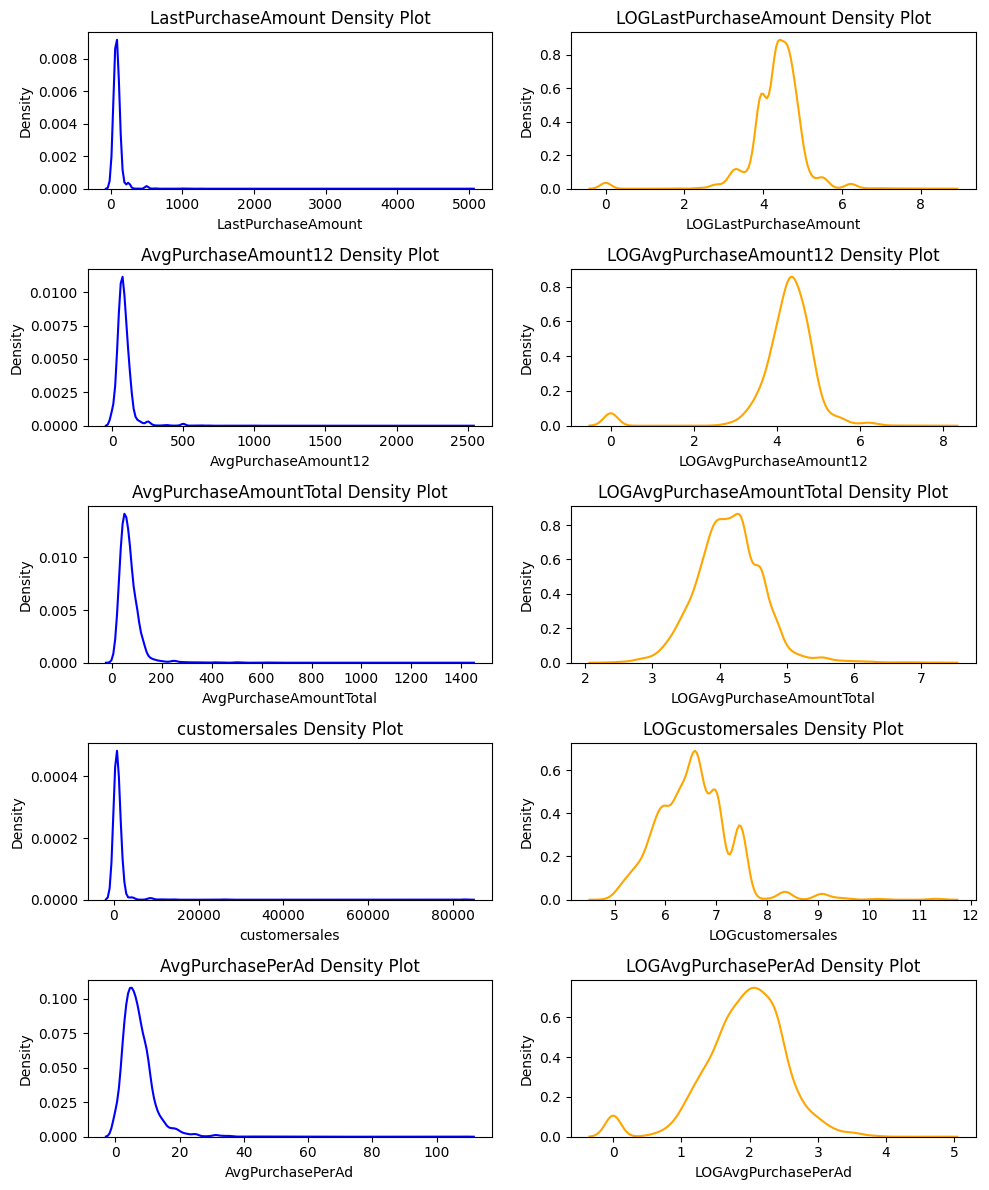

In [17]:
# PLots the difference between the distribution of the variables pre and post log transformation 

transform_summary = hist_compare(X_train, skewed_cols, log_cols, figsize = (10, 12))

In [18]:
# Updates the input list to include only log transformed columns

inputs = [col for col in inputs if col not in skewed_cols] + log_cols
numerics = [col for col in numerics if col not in skewed_cols] + log_cols

### One-Hot Encoding

One-Hot encodes the categorical column values. 

In [19]:
# Fits a one hot enconder using the categorical columns

ohe = OneHotEncoder(drop = "if_binary").fit(X_train[categoricals])

# Transforms both partitions

ohe_train = ohe.transform(X_train[categoricals]).toarray()
ohe_test = ohe.transform(X_test[categoricals]).toarray()

# Adds the new features to the partitions

ohe_features = ohe.get_feature_names_out()
X_train[ohe_features] = ohe_train
X_test[ohe_features] = ohe_test

In [20]:
# Drops non-OHE columns

X_train = X_train.drop(categoricals, axis = 1)
X_test = X_test.drop(categoricals, axis = 1)

# Updates the inputs and categoricals list

inputs = [col for col in inputs if col not in categoricals] + ohe_features.tolist()
categoricals = ohe_features.tolist()

In [21]:
# Display sample of the output

X_train[categoricals].head()

,customerGender_F,customerGender_M,customerGender_U,customerSubscrStat_Gold,customerSubscrStat_Member,customerSubscrStat_Platinum,demHomeOwner_Unknown
2195,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2822,0.0,1.0,0.0,0.0,0.0,1.0,1.0
835,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4268,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2227,1.0,0.0,0.0,0.0,0.0,1.0,1.0


### Variable Scaling

Scales the numeric columns based on their distribution.

In [22]:
# Standardizes the numeric columns so they have a similar scale

standardizer = StandardScaler()
standardizer = standardizer.fit(X_train[numerics])

In [23]:
# Applies the scaler to training and validation

X_train[numerics] = standardizer.transform(X_train[numerics])
X_test[numerics] = standardizer.transform(X_test[numerics])

In [24]:
# Displays the distribution of the numeric variables

X_train[numerics].describe().T

,count,mean,std,min,25%,50%,75%,max
regionPctCustomers,4000.0,-8.881784e-17,1.000125,-2.733022,-0.553057,-0.029866,0.580525,3.894072
numOfTotalReturns,4000.0,7.505108e-17,1.000125,-1.008847,-1.008847,-0.329260,0.350327,5.107435
wksSinceLastPurch,4000.0,2.993161e-16,1.000125,-3.027449,-0.431890,0.000703,0.433296,1.947372
basktPurchCount12Month,4000.0,-2.042810e-17,1.000125,-1.388814,-0.817697,-0.246580,0.895654,3.751240
intAdExposureCount12,4000.0,7.460699e-17,1.000125,-2.015351,-0.432062,-0.256141,0.095701,6.077015
intAdExposureCount36,4000.0,-1.509903e-16,1.000125,-2.613458,-0.533725,0.177762,0.560871,4.282499
socialMediaAdCount12,4000.0,6.927792e-17,1.000125,-2.630339,-0.819123,0.388355,0.388355,7.029483
socialMediaAdCount36,4000.0,-1.367795e-16,1.000125,-1.890096,-0.928606,0.032883,0.994372,3.301947
socialMediaAdCountAll,4000.0,1.225686e-16,1.000125,-1.750263,-0.878360,-0.006458,0.756458,3.481154
totalNumProdPurchased,4000.0,5.329071e-17,1.000125,-0.984415,-0.739848,-0.250712,0.482991,6.474898


### Feature Selection

Performs supervised and unsupervised feature selection. Unsupervised feature selection technique used is variance threshold. Supervised feature selection technique used are lasso selection and a decision tree selector. 

In [25]:
# Unsupervised Variable Selection - Variance Threshold

variance_selector = VarianceThreshold(threshold = 0.1)
variance_selector = variance_selector.fit(X_train[inputs])
variance_features = variance_selector.get_feature_names_out()

In [26]:
# Backwards Elimination Variable Selection

rfe_selector = RFE(estimator = LogisticRegressionCV(cv = 10))
rfe_selector = rfe_selector.fit(X_train[inputs], y_train)
rfe_features = rfe_selector.get_feature_names_out()

In [27]:
# Dtree Variable Selection

tree_selector = SelectFromModel(estimator = DecisionTreeClassifier(random_state = 42))
tree_selector = tree_selector.fit(X_train[inputs], y_train)
tree_features = tree_selector.get_feature_names_out()

In [28]:
# Displays the removed features

rm_variance_features = [col for col in variance_selector.feature_names_in_ if col not in variance_features]
rm_rfe_features = [col for col in rfe_selector.feature_names_in_ if col not in rfe_features]
rm_tree_features = [col for col in tree_selector.feature_names_in_ if col not in tree_features]

print("Variance Threshold Removed Features:", end = "\n\n")
print(rm_variance_features, end = "\n\n")

print("RFE Removed Features:", end = "\n\n")
print(rm_rfe_features, end = "\n\n")

print("Decision Tree Removed Features:", end = "\n\n")
print(rm_tree_features)

Variance Threshold Removed Features:

['customerGender_U', 'customerSubscrStat_Member']

RFE Removed Features:

['regionPctCustomers', 'wksSinceLastPurch', 'intAdExposureCount12', 'intAdExposureCount36', 'socialMediaAdCount12', 'totalNumProdPurchased', 'techSupportEval', 'customerAge', 'customerGender_F', 'customerGender_M', 'customerGender_U', 'customerSubscrStat_Member', 'customerSubscrStat_Platinum', 'demHomeOwner_Unknown']

Decision Tree Removed Features:

['numOfTotalReturns', 'wksSinceLastPurch', 'intAdExposureCount12', 'intAdExposureCount36', 'socialMediaAdCount12', 'socialMediaAdCount36', 'totalNumProdPurchased', 'custInitiatedContacts', 'wksSinceFirstPurch', 'EstimatedIncome', 'techSupportEval', 'customerAge', 'LOGAvgPurchaseAmountTotal', 'customerGender_F', 'customerGender_M', 'customerGender_U', 'customerSubscrStat_Gold', 'customerSubscrStat_Member', 'customerSubscrStat_Platinum', 'demHomeOwner_Unknown']


In [29]:
# Selects the features the tree used in both partitions

selected_features = [col for col in inputs if (col in variance_features) or (col in rfe_features) or (col in tree_features)]
selected_features

['regionPctCustomers',
 'numOfTotalReturns',
 'wksSinceLastPurch',
 'basktPurchCount12Month',
 'intAdExposureCount12',
 'intAdExposureCount36',
 'socialMediaAdCount12',
 'socialMediaAdCount36',
 'socialMediaAdCountAll',
 'totalNumProdPurchased',
 'custInitiatedContacts',
 'wksSinceFirstPurch',
 'EstimatedIncome',
 'regionMedHomeVal',
 'techSupportEval',
 'customerAge',
 'LOGLastPurchaseAmount',
 'LOGAvgPurchaseAmount12',
 'LOGAvgPurchaseAmountTotal',
 'LOGcustomersales',
 'LOGAvgPurchasePerAd',
 'customerGender_F',
 'customerGender_M',
 'customerSubscrStat_Gold',
 'customerSubscrStat_Platinum',
 'demHomeOwner_Unknown']